In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import torch
import torch.functional as F
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import defaultdict
from copy import deepcopy

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import MIMIC
from lib.eval import bootstrap

# Is the clean source and target task unbiased? Yes

In [2]:
task = 'Edema'
# task = 'Cardiomegaly'
m = MIMIC(task)

317410 unknown Edema value in mimic data


In [3]:
m.df[['is_male', task]].corr()

,is_male,Edema
is_male,1.000000,-0.009445
Edema,-0.009445,1.000000


In [4]:
def MI(x, y):
    '''
    mutual information between two binary attributes
    x and y are two equal length list
    '''
    def H(p):
        return - p * np.log(p) - (1-p) * np.log(1-p)
    
    px, py = x.mean(), y.mean()
    py_x, py_notx = y[x==1].mean(), y[x==0].mean()
    return H(py) - (px * H(py_x) + (1-px) * H(py_notx)), H(px), H(py)

mi, ht, hm = MI(m.df[task], m.df['is_male'])
print(mi, ht, hm)
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')

4.462104700964087e-05 0.6725106982356779 0.6867981495124605
I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


# Data statistics

In [68]:
n_samples = len(np.unique(m.df.subject_id))
n_males = len(np.unique(m.df[m.df.gender=='M'].subject_id))
n_females = len(np.unique(m.df[m.df.gender=='F'].subject_id))
print(f'{len(m.df)} x-rays, {len(np.unique(m.df.pt_id))} studies')
print(f'{n_samples} patients, {n_males} ({n_males/n_samples*100:.2f}%) male, {n_females} ({n_females/n_samples*100:.2f}%) female')

107510 x-rays, 62697 studies
22738 patients, 11307 (49.73%) male, 11431 (50.27%) female


In [66]:
print(f"P({task}) = {m.df[task].mean():.2f}")
print(f"P({task}|male) = {m.df[m.df.gender=='M'][task].mean():.2f}")
print(f"P({task}|female) = {m.df[m.df.gender=='F'][task].mean():.2f}")

P(Edema) = 0.60
P(Edema|male) = 0.60
P(Edema|female) = 0.61


In [55]:
m.df

,Unnamed: 0,index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,...,Support Devices,local_path,pt_id,split,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,17,35,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50578979,train,10000935,F,52,2182,2008 - 2010,NaN
1,26,52,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,58219844,train,10000935,F,52,2182,2008 - 2010,NaN
2,27,53,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
3,28,55,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,50985099,train,10000980,F,73,2186,2008 - 2010,NaN
4,32,62,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,...,-1.0,~/Fused/mimic-cxr/preprocessed_images//p10/p10...,54935705,train,10000980,F,73,2186,2008 - 2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107505,425895,729287,-1.0,1.0,1.0,-1.0,1.0,0.0,-1.0,-1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,55683952,train,19998843,M,45,2187,2011 - 2013,NaN
107506,425896,729288,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107507,425897,729289,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN
107508,425898,729290,-1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,...,1.0,~/Fused/mimic-cxr/preprocessed_images//p19/p19...,56350227,train,19998843,M,45,2187,2011 - 2013,NaN


# Threshold to Accuracy and Correlation

In [8]:
def subsample_gender(df, threshold):
    '''
    df is the mimic dataset
    remove male negative and female positive
    '''
    z = np.random.rand(len(df))
    drop = (df['gender'] == 'M') * (df[m.task] == 0) + (df['gender'] == 'F') * (df[m.task] == 1)
    drop = drop * (z <= threshold)
    new_df = df[~drop]
    return new_df
    
subsample_gender(m.df, 1)[['is_male', task]].corr()

,is_male,Edema
is_male,1.0,1.0
Edema,1.0,1.0


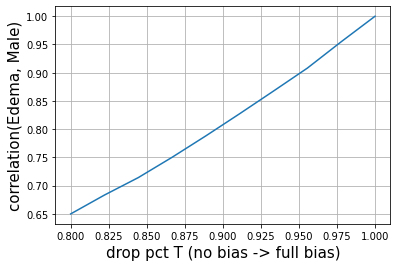

In [247]:
x = np.linspace(0.8, 1, 10)
correlation = [subsample_gender(m.df, t)[['is_male', task]].corr().iloc[0, 1] for t in x]
plt.plot(x, correlation, label=f'correlation({task}, male)')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel(f'correlation({task}, Male)', fontsize=15)
plt.grid()
# plt.legend(fontsize=15)
plt.show()

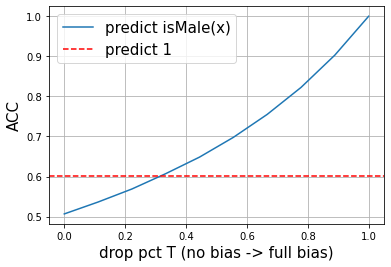

In [248]:
def ACC_male(m, t, task, f):
    '''
    accuracy of using isMale to predict task when subsampling at threshold t
    '''
    df = subsample_gender(m.df, t)
    return f(df[task], df['gender'] == 'M')

reduce_fn = metrics.accuracy_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('ACC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

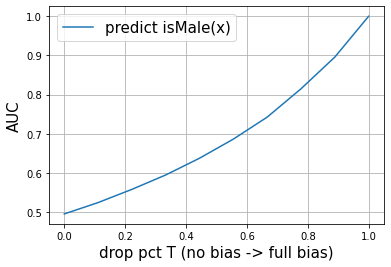

In [249]:
reduce_fn = metrics.roc_auc_score
x = np.linspace(0, 1, 10)
acc = [ACC_male(m, t, task, reduce_fn) for t in x]
plt.plot(x, acc, label='predict isMale(x)')
# plt.axhline(reduce_fn(m.df[task], np.ones_like(m.df[task])), ls='--', color='r', label='predict 1')
plt.xlabel('drop pct T (no bias -> full bias)', fontsize=15)
plt.ylabel('AUC', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.show()

# Per group investigation (automated)

In [250]:
methods = ['CCM EYE', 'CCM RES', 'STD(C,X)', 'CBM', 'STD(X)']
results = {m: defaultdict(dict) for m in methods} # results[method][x][key]

def get_approach_name(fn, alpha):
    name = fn.split('/')[-1].split('_')[0]
    if name == 'ccm' and alpha != 0:
        return methods[0]    
    elif name == 'ccmr':
        return methods[1]
    elif name == 'ccm' and alpha == 0:
        return methods[2]
    elif name == 'cbm':
        return methods[3]
    elif name == 'standard':
        return methods[4]    
    else:
        raise Exception(f"not defined name {name}")

In [251]:
def subsample_mimic(m, t, task): # m is a df
    np.random.seed(42)
    z = np.random.rand(len(m))
    drop = (m['gender'] == 'M') * (m[task] == 0) + (m['gender'] == 'F') * (m[task] == 1)
    drop = drop * (z <= t)
    m_test = m[~drop]
    return m_test
    
def get_test(m): # m is a df
    indices = list(range(len(m)))
    labels = list(m[task])
    _, test_indices = train_test_split(indices, stratify=labels, random_state=42)
    m_test = m.iloc[test_indices]
    return m_test

def get_non_subsample_test(m, t, task): # m is a df
    # unbiased and not using train val from biased training
    np.random.seed(42)
    z = np.random.rand(len(m))
    drop = (m['gender'] == 'M') * (m[task] == 0) + (m['gender'] == 'F') * (m[task] == 1)
    drop = drop * (z <= t)
    # print(np.array(~drop).nonzero()[0])
    indices = list(np.array(~drop).nonzero()[0])
    labels = list(m[task].iloc[indices])
    trval_indices, _ = train_test_split(indices, stratify=labels, random_state=42)
    
    # resample
    indices = list(range(len(m)))
    labels = list(m[task])
    _, test_indices = train_test_split(indices, stratify=labels, random_state=42)
    
    # exclude trval
    # print('before', len(test_indices))
    test_indices = list(set(test_indices) - set(trval_indices))
    # print('after', len(test_indices))
    
    m_test = m.iloc[test_indices]
    return m_test

def get_non_subsample_test_corr(m, t, task, mpfn_proportion): # m is a df
    '''
    mpfn_proportion varies from 0 to 1, 0.5 is uncorrelation, 0 is corr -1, 1 is corr 1
    '''
    assert 0 <= mpfn_proportion <= 1, "proportion need to be within [0,1]"
    np.random.seed(42)
    z = np.random.rand(len(m))
    drop = (m['gender'] == 'M') * (m[task] == 0) + (m['gender'] == 'F') * (m[task] == 1)
    drop = drop * (z <= t)
    # print(np.array(~drop).nonzero()[0])
    indices = list(np.array(~drop).nonzero()[0])
    labels = list(m[task].iloc[indices])
    trval_indices, _ = train_test_split(indices, stratify=labels, random_state=42)
    test_indices = list(set(range(len(m))) - set(trval_indices))
    
    # resample    
    m_test = m.iloc[test_indices]
    mp_fn = np.array((m_test['gender'] == 'M') * (m_test[task] == 1) + (m_test['gender'] == 'F') * (m_test[task] == 0))
    n_mpfn = sum(mp_fn)
    n = min(n_mpfn, len(m_test) - n_mpfn)
    mp_fn_indices = np.random.permutation(mp_fn.nonzero()[0])[:int(mpfn_proportion * n)]
    mn_fp_indices = np.random.permutation((~mp_fn).nonzero()[0])[:n-int(mpfn_proportion * n)]
    return m_test.iloc[np.hstack([mp_fn_indices, mn_fp_indices])]

get_non_subsample_test_corr(m.df, 0.9, task, 0.5)[['is_male', task]].corr()


,is_male,Edema
is_male,1.000000,-0.021778
Edema,-0.021778,1.000000


In [306]:
filenames = [ # name, t, alpha
    # # t = 1
    # ('../outputs/6cdf0ea84be111ecb773ac1f6b24a434/ccmr_Edema.npz', 1, None),
    # ('../outputs/e517dabe4bda11ecb773ac1f6b24a434/ccm_Edema.npz', 1, 0),
    # ('../outputs/69a2c0ca4b6b11ecb773ac1f6b24a434/ccm_Edema.npz', 1, 0.01),
    # ('../outputs/6cae42984b0d11ecb773ac1f6b24a434/standard_Edema.npz', 1, None),
    # ('../outputs/39db3dee4b0d11ecb773ac1f6b24a434/cbm_Edema.npz', 1, None),
    # # t = 0.975
    # ('../outputs/21412056620911ec830e8fa97a4e8129/ccmr_Edema.npz', 0.975, None),
    # ('../outputs/7e53e8f661b311ec830e8fa97a4e8129/ccm_Edema.npz', 0.975, 0),
    # ('../outputs/c9a321f261ac11ec830e8fa97a4e8129/ccm_Edema.npz', 0.975, 1e-2),
    # ('../outputs/cfa9fff0617811ec830e8fa97a4e8129/cbm_Edema.npz', 0.975, None),
    # ('../outputs/ed0b99ba614f11ec830e8fa97a4e8129/standard_Edema.npz', 0.975, None),    
    # # t = 0.95
    # ('../outputs/a67cb9785f0811ec830e8fa97a4e8129/standard_Edema.npz', 0.95, None),
    # ('../outputs/579ec276620311ec830e8fa97a4e8129/ccmr_Edema.npz', 0.95, None),
    # ('../outputs/4643a8d2616a11ec830e8fa97a4e8129/cbm_Edema.npz', 0.95, None),
    # ('../outputs/fc58903e616911ec830e8fa97a4e8129/ccm_Edema.npz', 0.95, 0),
    # ('../outputs/86ccb66a616411ec830e8fa97a4e8129/ccm_Edema.npz', 0.95, 1e-2),
    # # t = 0.925
    # ('../outputs/7fcfa8a661fd11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.925, None),
    # ('../outputs/c0c1a2da618d11ec830e8fa97a4e8129/ccm_Edema.npz', 0.925, 0),
    # ('../outputs/342e322a618311ec830e8fa97a4e8129/ccm_Edema.npz', 0.925, 1e-2),
    # ('../outputs/d35ee6be615b11ec830e8fa97a4e8129/cbm_Edema.npz', 0.925, None),
    # ('../outputs/601c7e16614511ec830e8fa97a4e8129/standard_Edema.npz', 0.925, None),
    # # t = 0.9
    # ('../outputs/7b0a1aac4b6111ecb773ac1f6b24a434/ccm_Edema.npz', 0.9, 0.01),
    # ('../outputs/5a4ce99a4b3711ecb773ac1f6b24a434/standard_Edema.npz', 0.9, None),
    # ('../outputs/5df7a9fe4b3711ecb773ac1f6b24a434/cbm_Edema.npz', 0.9, None),
    # ('../outputs/36dbcf544bf911ecb773ac1f6b24a434/ccm_Edema.npz', 0.9, 0),
    # ('../outputs/4e5eb1be4bdb11ecb773ac1f6b24a434/ccmr_Edema.npz', 0.9, None),
    # t = 0.87
    ('../outputs/a5dde380758211ec830e8fa97a4e8129/ccm_Edema.npz', 0.87, 0.01),
    ('../outputs/360706e2750d11ec830e8fa97a4e8129/standard_Edema.npz', 0.87, None),
    ('../outputs/f135e60a750c11ec830e8fa97a4e8129/cbm_Edema.npz', 0.87, None),
    ('../outputs/12934eb0758e11ec830e8fa97a4e8129/ccm_Edema.npz', 0.87, 0),
    ('../outputs/dde98f96757c11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.87, None),    
    # t = 0.83
    ('../outputs/8ae30358758211ec830e8fa97a4e8129/ccm_Edema.npz', 0.83, 0.01),
    ('../outputs/2f87b5e6750d11ec830e8fa97a4e8129/standard_Edema.npz', 0.83, None),
    ('../outputs/ce6dbddc750c11ec830e8fa97a4e8129/cbm_Edema.npz', 0.83, None),
    ('../outputs/1fd20566758a11ec830e8fa97a4e8129/ccm_Edema.npz', 0.83, 0),
    ('../outputs/c91ab450757c11ec830e8fa97a4e8129/ccmr_Edema.npz', 0.83, None),
    # # t = 0.8
    # ('../outputs/86698a8046bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0),
    # ('../outputs/404868d246bc11ecb773ac1f6b24a434/ccm_Edema.npz', 0.8, 0.01),
    # ('../outputs/3f45f33446ba11ecb773ac1f6b24a434/ccmr_Edema.npz', 0.8, None),
    # ('../outputs/f77275b2425611ecb773ac1f6b24a434/standard_Edema.npz', 0.8, None),
    # ('../outputs/80b3060c420211ecb773ac1f6b24a434/cbm_Edema.npz', 0.8, None),
]

for fn, t, alpha in filenames:
    task = fn.split('/')[-1].split('_')[-1].split('.')[0]
    method_name = get_approach_name(fn, alpha)
    output = torch.load(fn)
    m = MIMIC(task)
    m.df['output'] = softmax(output, 1)[:, 1]
            
    # gather result
    metric = metrics.roc_auc_score     
    ################ AUC results
    # m_sub = subsample_gender(get_test(m.df), t) 
    m_sub = get_test(subsample_mimic(m.df, t, m.task)) # no train
    y, yhat = m_sub[task], m_sub['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['biased'] = [l, metric(y, yhat), r]
    
    # unbiased and not using train val from biased training
    for i in np.linspace(0, 1, 11):
        m_test = get_non_subsample_test_corr(m.df, t, m.task, i)
        y, yhat = m_test[task], m_test['output']
        l, r = bootstrap(metric, y, yhat)
        results[method_name][t][f"{i:.1f}"] = [l, metric(y, yhat), r]
    
    # m_test = get_non_subsample_test(m.df, t, m.task) # -0.6 corr
    m_test = get_test(m.df) # 0 correlation
    y, yhat = m_test[task], m_test['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['clean'] = [l, metric(y, yhat), r]
    
    m_test = get_test(m.df) # 0 correlation
    y, yhat = m_test['is_male'], m_test['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['isMale'] = [l, metric(y, yhat), r]

    metric = lambda y, yhat: (y == (yhat > 0.5)).mean()
    ################# ACC results
    mp = lambda m: m[(m['is_male']==1) * (m[task]==1)]
    y, yhat = mp(m_test)[task], mp(m_test)['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['male positive'] = [l, metric(y, yhat), r]
    
    mn = lambda m: m[(m['is_male']==1) * (m[task]==0)]    
    y, yhat = mn(m_test)[task], mn(m_test)['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['male negative'] = [l, metric(y, yhat), r]

    fp = lambda m: m[(m['is_male']==0) * (m[task]==1)]
    y, yhat = fp(m_test)[task], fp(m_test)['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['female positive'] = [l, metric(y, yhat), r]

    fn = lambda m: m[(m['is_male']==0) * (m[task]==0)]
    y, yhat = fn(m_test)[task], fn(m_test)['output']
    l, r = bootstrap(metric, y, yhat)
    results[method_name][t]['female negative'] = [l, metric(y, yhat), r]

317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data
317410 unknown Edema value in mimic data


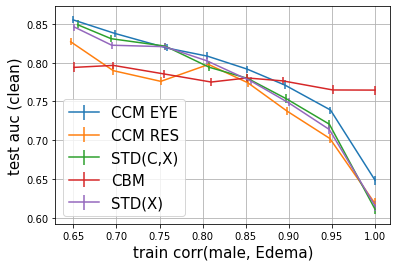

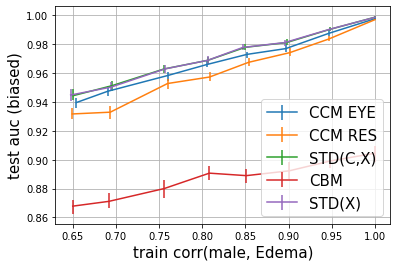

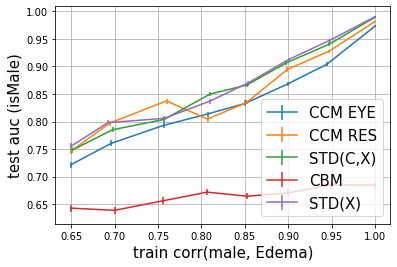

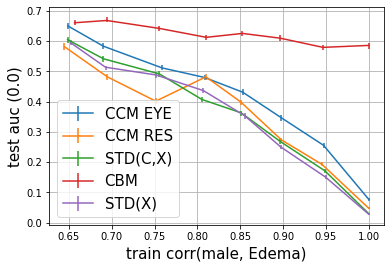

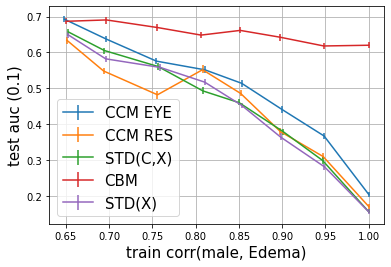

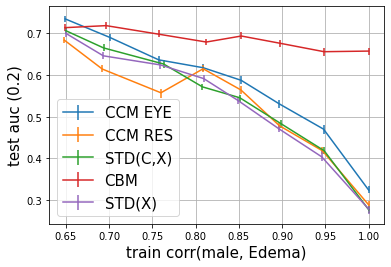

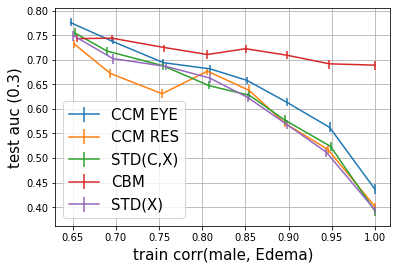

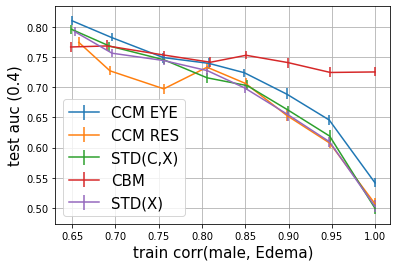

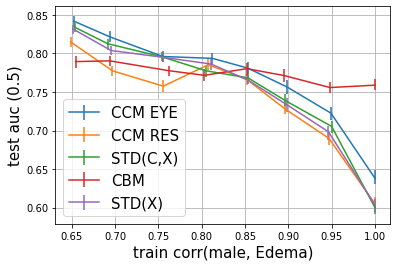

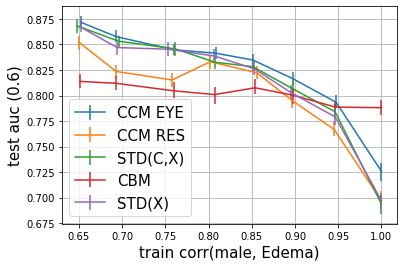

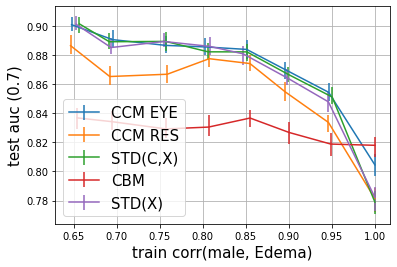

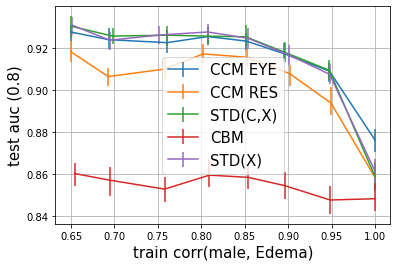

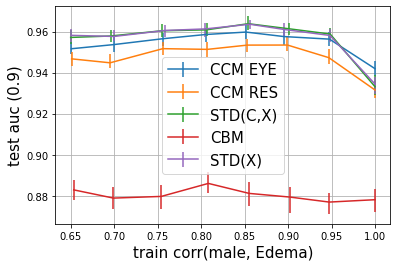

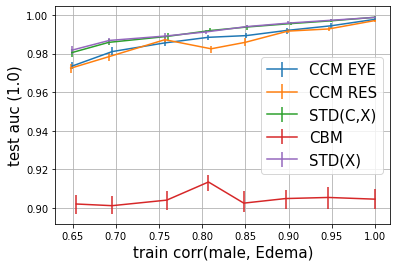

In [307]:
# plot result
def plot_results(results, method_name, key, display_x=lambda x: x):
    x = sorted(results[method_name].keys())
    values = np.array([results[method_name][x_][key] for x_ in x]) # (n, 3)
    y = values[:, 1]
    yerr = np.vstack([y - values[:, 0], values[:, 2] - y])
    x_display = [display_x(x_) for x_ in x]
    plt.errorbar(x_display, y, yerr=yerr, label=method_name)
        
# keys = ['clean', 'biased', 'isMale', 'male positive', 'male negative', 'female positive', 'female negative']
# m = MIMIC(task)
train_corr_display_x = lambda x: subsample_gender(m.df, x)[['is_male', task]].corr().iloc[0, 1]
for key in ['clean', 'biased', 'isMale', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']:
    xlabel = f"train corr(male, {task})"
    plot_results(results, 'CCM EYE', key, train_corr_display_x)
    plot_results(results, 'CCM RES', key, train_corr_display_x)
    plot_results(results, 'STD(C,X)', key, train_corr_display_x)
    plot_results(results, 'CBM', key, train_corr_display_x)
    plot_results(results, 'STD(X)', key, train_corr_display_x)
    plt.ylabel(f'test auc ({key})', fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()



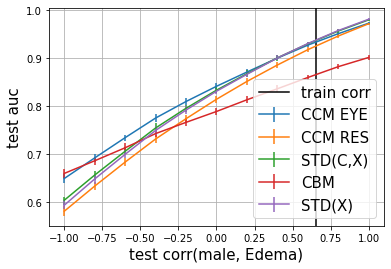

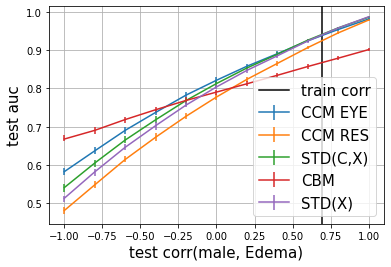

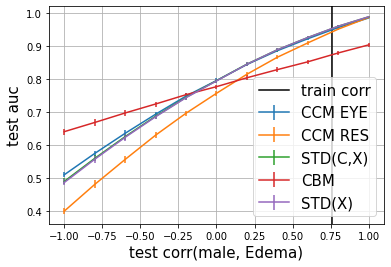

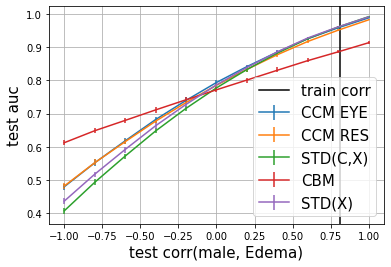

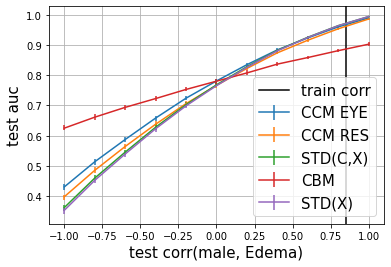

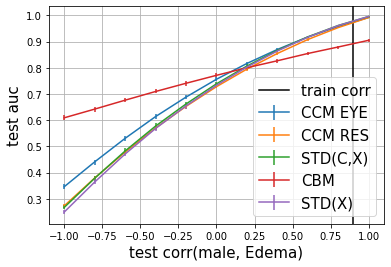

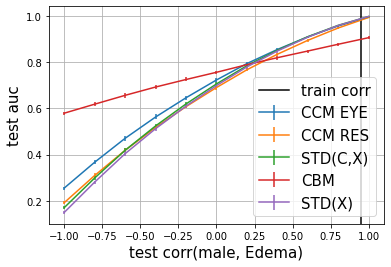

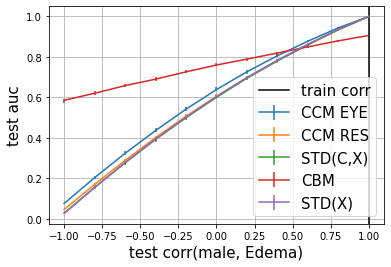

In [308]:
# plot result
def get_results_transpose(results, method_names, keys):
    '''
    change from (keys, train corr) to  (train corr, keys)
    '''
    tresults = {m: defaultdict(dict) for m in method_names} # results[method][x][key]
    for method_name in method_names:
        x = sorted(results[method_name].keys())
        for k in keys:
            for x_ in x:
                tresults[method_name][float(k)][x_] = results[method_name][x_][k]
                
    return tresults

# keys = ['clean', 'biased', 'isMale', 'male positive', 'male negative', 'female positive', 'female negative']
tresults = get_results_transpose(results, methods, ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
test_corr_display_x = lambda x: (x-0.5) * 2
for key in [0.8, 0.83, 0.87, 0.9, 0.925, 0.95, 0.975, 1]:
    xlabel = f"test corr(male, {task})"
    plot_results(tresults, 'CCM EYE', key, test_corr_display_x)
    plot_results(tresults, 'CCM RES', key, test_corr_display_x)
    plot_results(tresults, 'STD(C,X)', key, test_corr_display_x)
    plot_results(tresults, 'CBM', key, test_corr_display_x)
    plot_results(tresults, 'STD(X)', key, test_corr_display_x)
    plt.axvline(train_corr_display_x(key), color='k', label="train corr")
    plt.ylabel(f'test auc', fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()



Not able to do this plot for CUB because both Noise and Y are not binary for CUB (so correlation cannot be calculated). This plot shows that when the testing distribution deviate from the training, CCM EYE is consistently better than baselines other than CBM. Compared to CBM, CCM EYE still does better when the test distribution does not deviate from the training distribution too much (as abrupt change in the patient population are unlikely).

In [268]:
a = get_non_subsample_test_corr(m.df, 0.9, task, 0)
print(len(a))
a[['is_male', task]].corr()

13584


,is_male,Edema
is_male,1.0,-1.0
Edema,-1.0,1.0


In [220]:
get_test(m.df)[['is_male', task]].corr()

,is_male,Edema
is_male,1.000000,-0.010851
Edema,-0.010851,1.000000


# Per group investigation (manual)

In [171]:
t = 0.975
# fn = '../outputs/21412056620911ec830e8fa97a4e8129/ccmr_Edema.npz'
# fn = '../outputs/bc5311c261c711ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-3
# fn = '../outputs/f296344c61ba11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-1
# fn = '../outputs/7e53e8f661b311ec830e8fa97a4e8129/ccm_Edema.npz' # 0
fn = '../outputs/c9a321f261ac11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-2
# fn = '../outputs/cfa9fff0617811ec830e8fa97a4e8129/cbm_Edema.npz'
# fn = '../outputs/ed0b99ba614f11ec830e8fa97a4e8129/standard_Edema.npz'

# t = 0.95
# fn = '../outputs/a67cb9785f0811ec830e8fa97a4e8129/standard_Edema.npz'
# fn = '../outputs/579ec276620311ec830e8fa97a4e8129/ccmr_Edema.npz'
# fn = '../outputs/f1bb5a7c617c11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-3
# fn = '../outputs/77873152616f11ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-1
# fn = '../outputs/4643a8d2616a11ec830e8fa97a4e8129/cbm_Edema.npz'
# fn = '../outputs/fc58903e616911ec830e8fa97a4e8129/ccm_Edema.npz' # 0
# fn = '../outputs/86ccb66a616411ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-2

# t = 0.925
# fn = '../outputs/7fcfa8a661fd11ec830e8fa97a4e8129/ccmr_Edema.npz'
# fn = '../outputs/096f3fe661a311ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-3
# fn = '../outputs/076d6aca619811ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-1
# fn = '../outputs/c0c1a2da618d11ec830e8fa97a4e8129/ccm_Edema.npz' # 0
# fn = '../outputs/342e322a618311ec830e8fa97a4e8129/ccm_Edema.npz' # 1e-2
# fn = '../outputs/d35ee6be615b11ec830e8fa97a4e8129/cbm_Edema.npz'
# fn = '../outputs/601c7e16614511ec830e8fa97a4e8129/standard_Edema.npz'

# t=0.9
# fn = '../outputs/7b0a1aac4b6111ecb773ac1f6b24a434/ccm_Edema.npz'
# fn = '../outputs/5a4ce99a4b3711ecb773ac1f6b24a434/standard_Edema.npz'
# fn = '../outputs/5df7a9fe4b3711ecb773ac1f6b24a434/cbm_Edema.npz'

task = fn.split('/')[-1].split('_')[-1].split('.')[0]
output = torch.load(fn)
m = MIMIC(task)
print(output.shape) # 200 is a mistake but it shouldn't change the result in any way
m.df['output'] = softmax(output, 1)[:, 1]

317410 unknown Edema value in mimic data
(107510, 2)


In [172]:
indices = list(range(len(m)))
labels = list(m.df[task])
_, test_indices = train_test_split(indices, stratify=labels, random_state=42)
m_test = m.df.iloc[test_indices]
m_test[[task, 'is_male', 'output']].mean()

Edema      0.601235
is_male    0.553836
output     0.618673
dtype: float64

In [173]:
metric = metrics.roc_auc_score
y, yhat = m_test[task], m_test['output']
print(f'AUC {task} (clean):', metric(y, yhat), bootstrap(metric, y, yhat))

m_sub = subsample_gender(m_test, t)
y, yhat = m_sub[task], m_sub['output']
print(f'AUC {task} T={t}:', metric(y, yhat), bootstrap(metric, y, yhat))

y, yhat = m_test['is_male'], m_test['output']
print(f'AUC is_male:', metric(y, yhat), bootstrap(metric, y, yhat))

AUC Edema (clean): 0.7390221744580691 (0.7323477674325503, 0.7441366299528834)
AUC Edema T=0.975: 0.9883700971426138 (0.9867202804044289, 0.9900180312411331)
AUC is_male: 0.9038892351943707 (0.9003795825814397, 0.907271312629891)


In [92]:
print('average softmax prediction Male   Edema=1: {:.2f}'.format(m_test[(m_test['is_male']==1) * (m_test[task]==1)]['output'].mean()))
print('average softmax prediction Male   Edema=0: {:.2f}'.format(m_test[(m_test['is_male']==1) * (m_test[task]==0)]['output'].mean()))
print('average softmax prediction Female Edema=1: {:.2f}'.format(m_test[(m_test['is_male']==0) * (m_test[task]==1)]['output'].mean()))
print('average softmax prediction Female Edema=0: {:.2f}'.format(m_test[(m_test['is_male']==0) * (m_test[task]==0)]['output'].mean()))

average softmax prediction Male   Edema=1: 0.96
average softmax prediction Male   Edema=0: 0.65
average softmax prediction Female Edema=1: 0.48
average softmax prediction Female Edema=0: 0.08


In [93]:
mp = lambda m: m[(m['is_male']==1) * (m[task]==1)]
mn = lambda m: m[(m['is_male']==1) * (m[task]==0)]
fp = lambda m: m[(m['is_male']==0) * (m[task]==1)]
fn = lambda m: m[(m['is_male']==0) * (m[task]==0)]

y, yhat = mp(m_test)[task], mp(m_test)['output']
a_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for male positive:', a_)

y, yhat = mn(m_test)[task], mn(m_test)['output']
b_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for male negative:', b_)

y, yhat = fp(m_test)[task], fp(m_test)['output']
c_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for female positive:', c_)

y, yhat = fn(m_test)[task], fn(m_test)['output']
d_ = (y == (yhat > 0.5)).mean()
print(f'ACC {task} (clean) for female negative:', d_)

print(f'ACC {task} (clean) for MP, MN, FP, FN are {t}: [{a_*100:.1f}, {b_*100:.1f}, {c_*100:.1f}, {d_*100:.1f}],')

ACC Edema (clean) for male positive: 0.9876112174794459
ACC Edema (clean) for male negative: 0.31163642417179954
ACC Edema (clean) for female positive: 0.47232523005081717
ACC Edema (clean) for female negative: 0.9622160900021227
ACC Edema (clean) for MP, MN, FP, FN are 0.925: [98.8, 31.2, 47.2, 96.2],


# Others

In [12]:
y, yhat = m_test[task], m_test['output']
print(f'ACC {task} (clean):', (y == (yhat > 0.5)).mean())

y, yhat = m_test['is_male'], m_test['output']
print(f'ACC is_male:', (y == (yhat > 0.5)).mean())

y, yhat = m_test[m_test['is_male']==1][task], m_test[m_test['is_male']==1]['output']
print(f'ACC {task} for male:', (y == (yhat > 0.5)).mean())

y, yhat = m_test[m_test['is_male']==0][task], m_test[m_test['is_male']==0]['output']
print(f'ACC {task} for female:', (y == (yhat > 0.5)).mean())

ACC Edema (clean): 0.610536498251358
ACC is_male: 0.8851104992931021
ACC Edema for male: 0.6698239957006583
ACC Edema for female: 0.5369412941961308


In [199]:
metrics.roc_auc_score(m_test['is_male'], m_test['output'])

0.8368912804469851

In [200]:
q0, q1, q2, q3 = np.percentile(m_test['output'], [0, 25, 50, 75])

In [201]:
m_test[(m_test['output'] >= q0) * (m_test['output'] <= q1)][[task, 'is_male', 'output']].mean()

Edema      0.247917
is_male    0.168304
output     0.047949
dtype: float64

In [202]:
m_test[(m_test['output'] >= q1) * (m_test['output'] <= q2)][[task, 'is_male', 'output']].mean()

Edema      0.532222
is_male    0.440839
output     0.462149
dtype: float64

In [203]:
m_test[(m_test['output'] >= q2) * (m_test['output'] <= q3)][[task, 'is_male', 'output']].mean()

Edema      0.717220
is_male    0.688942
output     0.917055
dtype: float64

In [204]:
m_test[(m_test['output'] >= q3)][[task, 'is_male', 'output']].mean()

Edema      0.907589
is_male    0.917262
output     0.995925
dtype: float64

In [232]:
mi, ht, hm = MI(m_test[task], m_test['is_male'])
print(f'I({task}; male) = {mi:.2f}, I({task}; male)/H({task}) = {mi/ht:.2f}, I({task}; male)/H(male) = {mi/hm:.2f}')
m_test[['is_male', task]].corr()

I(Edema; male) = 0.00, I(Edema; male)/H(Edema) = 0.00, I(Edema; male)/H(male) = 0.00


,is_male,Edema
is_male,1.000000,-0.010851
Edema,-0.010851,1.000000


# EYE illustration

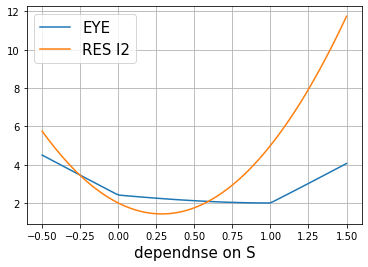

In [286]:
# unnormalized input setting X=(C, (S+U), U), C=S, U=C+E, var(S)=var(C)=var(U)=1, Y=C+U
x = np.linspace(-0.5, 1.5, 100)
a = x 
# a = np.sqrt(2) * x
b = (1-x)
c = (1-x)
plt.plot(x, abs(a)+abs(b) + np.sqrt((abs(a)+abs(b))**2 + c**2), label='EYE')
plt.plot(x, 2 * (1-x)**2 + x**2 + (2*x)**2, label='RES l2')

plt.grid()
plt.xlabel('dependnse on S', fontsize=15)
plt.legend(fontsize=15)


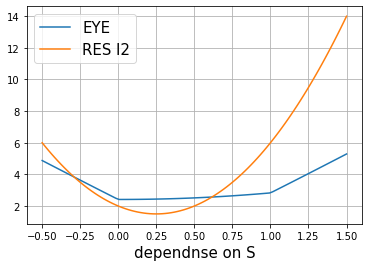

In [285]:
# normalized setting
x = np.linspace(-0.5, 1.5, 100)
# a = x 
a = np.sqrt(2) * x
b = (1-x)
c = (1-x)
plt.plot(x, abs(a)+abs(b) + np.sqrt((abs(a)+abs(b))**2 + c**2), label='EYE')
plt.plot(x, 2*(1-x)**2 + (2*x)**2 + 2*x**2, label='RES l2')

plt.grid()
plt.xlabel('dependnse on S', fontsize=15)
plt.legend(fontsize=15)
